# Recommendation System for MarketPlace Apparel Products

- Itens similarity: recommends similar items from another sellers
- Domain similarity: recommends items from domains which other similar users also buy

---
### Setup

In [70]:
# Importação das bibliotecas necessárias
import string
from unidecode import unidecode
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
from PIL import Image
import matplotlib.pyplot as plt
import os

import session_info

In [2]:
session_info.show(html=False)

-----
PIL                 11.0.0
matplotlib          3.9.2
numpy               2.1.2
pandas              2.2.3
session_info        1.0.0
sklearn             1.5.2
unidecode           NA
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.2.5
notebook            7.2.2
-----
Python 3.12.6 (main, Sep  6 2024, 19:03:47) [Clang 15.0.0 (clang-1500.3.9.4)]
macOS-14.6.1-x86_64-i386-64bit
-----
Session information updated at 2024-10-23 13:16


---
### Functions

In [3]:
# Função para carregar e achatar as imagens
def carregar_e_achatar_imagens(df, modo_cor='rgb', tamanho_imagem=(64, 64)):
    imagens = []
    ids = []
    for idx, row in df.iterrows():
        caminho_img = row['thumbnail_path']
        try:
            # Abre a imagem do caminho especificado
            img = Image.open(caminho_img)
            # Redimensiona a imagem para um tamanho padrão para uniformizar
            img = img.resize(tamanho_imagem)
            if modo_cor == 'grayscale':
                # Converte a imagem para escala de cinza
                img = img.convert('L')
                # Converte a imagem em um array numpy e achata em um vetor 1D
                img_array = np.array(img).flatten()
            else:
                # Garante que a imagem está em modo RGB
                img = img.convert('RGB')
                # Converte a imagem em um array numpy e achata em um vetor 1D
                img_array = np.array(img).flatten()
            # Adiciona o vetor de imagem à lista de imagens
            imagens.append(img_array)
            # Armazena o item_id correspondente
            ids.append(row['item_id'])
        except Exception as e:
            # Em caso de erro ao carregar a imagem, imprime o erro e continua
            print(f"Erro ao carregar a imagem {caminho_img}: {e}")
            continue
    # Retorna um array numpy das imagens e a lista de ids
    return np.array(imagens), ids

In [14]:
def clean_text(text: str) -> str:
    """
    Method to clean up and stardarize text data
    """
    
    # Convert to lower case
    text = text.lower()
    # Remove accent
    text = unidecode(text)
    # Remove ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = ''.join([i for i in text if not i.isdigit()])
    # Remove spaces
    text = text.strip()

    return text

---
### Read and Process Data

In [6]:
sample_items_meli = pd.read_csv('sample_items_meli.csv')

In [7]:
sample_items_meli.shape

(15270, 5)

In [8]:
categorias_distintas = len(set(sample_items_meli['ITE_ITEM_DOM_DOMAIN_ID']))
categorias_distintas

832

In [9]:
# Removing domains with few orders using cumulative sum (threshold = 55%)
# value obtained by testing some thresholds and checking the remaining domains till it gets more domains related to clothing or makeup
domain_vc = sample_items_meli.ITE_ITEM_DOM_DOMAIN_ID.value_counts().reset_index()
domain_vc.loc[:, "cum_sum"] = domain_vc.loc[:, "count"].cumsum()
domain_vc["%_acum"] = domain_vc.loc[:, "cum_sum"] / domain_vc.loc[:, "count"].sum()
domains_to_keep = domain_vc[domain_vc["%_acum"]<=0.55]["ITE_ITEM_DOM_DOMAIN_ID"].values
sample_items_meli_mod = sample_items_meli[sample_items_meli.ITE_ITEM_DOM_DOMAIN_ID.isin(domains_to_keep)].reset_index(drop=True)

In [10]:
# Clean item title
sample_items_meli_mod.loc[:, "clean_title"] = sample_items_meli_mod.loc[:, "ITE_ITEM_TITLE"].apply(clean_text)

In [11]:
sample_items_meli_mod.shape, len(set(sample_items_meli_mod['ITE_ITEM_DOM_DOMAIN_ID']))

((8348, 6), 54)

In [12]:
sample_items_meli_mod.head()

,item_id,ITE_ITEM_TITLE,ITE_ITEM_DOM_DOMAIN_ID,buyer_ID,thumbnail_path,clean_title
0,MLB2619201839,Sandália Infantil Feminina Chinelo Flamingo Mo...,MLB-SANDALS_AND_CLOGS,1375,item_thumbs/877474-MLB49725310569_042022.jpeg,sandalia infantil feminina chinelo flamingo mo...
1,MLB3751098364,Spot Trilho Duplo 2 Sobrepor Direcionável E-27...,MLB-WALL_AND_CEILING_LIGHTS,1380,item_thumbs/849578-MLU77154677816_072024.jpeg,spot trilho duplo sobrepor direcionavel e bra...
2,MLB3079601422,Umidificador Ar Portatil Ultrassonico Britania...,MLB-ELECTRIC_OIL_DIFFUSERS_HUMIDIFIERS_AND_VAP...,2593,item_thumbs/653292-MLB51210265777_082022.jpeg,umidificador ar portatil ultrassonico britania...
3,MLB3095457794,Sapato Mocassim Loafer Beira Rio Conforto Orig...,MLB-LOAFERS_AND_OXFORDS,3849,item_thumbs/814106-MLB53091315903_122022.jpeg,sapato mocassim loafer beira rio conforto orig...
4,MLB4667345894,Touca Gorro Cirúrgica Enfermagem Lilo & Stitch,MLB-HATS_AND_CAPS,4422,item_thumbs/981304-MLB78213957830_082024.jpeg,touca gorro cirurgica enfermagem lilo stitch


In [15]:
# Split in train and test 
# train set: pool of itens to generate similar itens
# test set: pool of itens to use as seem by the buyer while browsing  
train, test = train_test_split(sample_items_meli_mod, 
                               test_size=0.1,
                               stratify=sample_items_meli_mod.ITE_ITEM_DOM_DOMAIN_ID,
                               random_state=42)

In [16]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

---
### Analysis

##### Items Similarity

- Creating Image Embeddings

In [17]:
#### TRAIN
# Carrega e achata as imagens em RGB
train_images, _ = carregar_e_achatar_imagens(train, modo_cor='rgb', tamanho_imagem=(120, 120))
# Standarizing images
scaler = StandardScaler()
train_images_sc = scaler.fit_transform(train_images)
# Apply PCA to reduce image vector sizes
pca = PCA(n_components=1000)
train_images_pca = pca.fit_transform(train_images_sc)

In [18]:
#### TEST
# Carrega e achata as imagens em RGB
test_images, _ = carregar_e_achatar_imagens(test, modo_cor='rgb', tamanho_imagem=(120, 120))
# Standarizing images
test_images_sc = scaler.transform(test_images)
# Apply PCA to reduce image vector sizes
test_images_pca = pca.transform(test_images_sc)

In [19]:
train_images_pca.shape, test_images_pca.shape

((7513, 1000), (835, 1000))

- Creating Text Embeddings

In [20]:
##### TRAIN
# Create tf idf vectors
text_vec = TfidfVectorizer(max_features=5000)
tf_idf_train = text_vec.fit_transform(train.clean_title)
# Apply PCA to reduce dimensionality and sparsity
pca_text = PCA(n_components=500)
tf_idf_train_pca = pca_text.fit_transform(tf_idf_train)

In [21]:
##### TEST
# Create tf idf vectors
tf_idf_test = text_vec.transform(test.clean_title)
# Apply PCA to reduce dimensionality and sparsity
tf_idf_test_pca = pca_text.transform(tf_idf_test)

In [22]:
tf_idf_train_pca.shape, tf_idf_test_pca.shape

((7513, 500), (835, 500))

- Apply cosine similarity and agg scores

In [46]:
# Get example item
idx = 0
# Calculate img embeddings cosine similarity
selected_item_img = test_images_pca[idx]
cos_sim_img = cosine_similarity(selected_item_img.reshape(1,-1), train_images_pca)
# Calculate text embeddings cosine similarity
selected_item_text = tf_idf_test_pca[idx]
cos_sim_text = cosine_similarity(selected_item_text.reshape(1,-1), tf_idf_train_pca)
# Agg scores - here we can test many agg strategies and evaluate the best one
sim_scores = 0.3 * cos_sim_img + 0.7 * cos_sim_text #np.maximum.reduce([cos_sim_img, cos_sim_text], axis=0) 

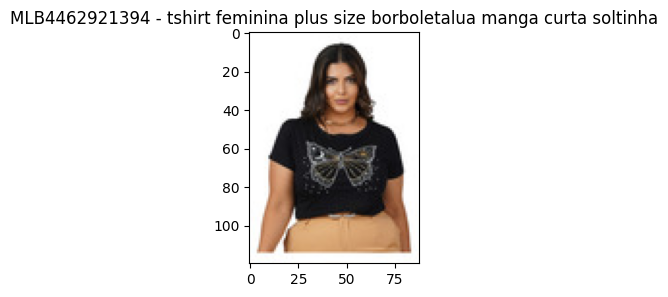

In [47]:
# Selected item
img = Image.open(test.loc[idx, "thumbnail_path"])
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(img)
_=ax.set_title(f"{test.loc[idx, 'item_id']} - {test.loc[idx, 'clean_title']}")

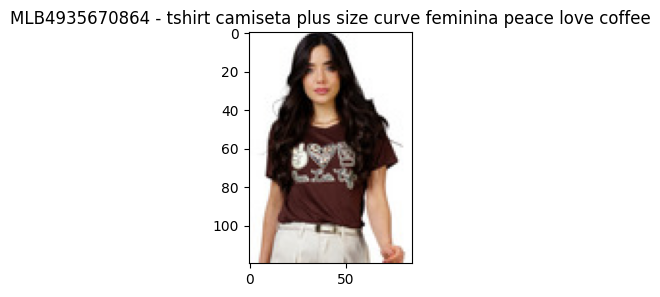

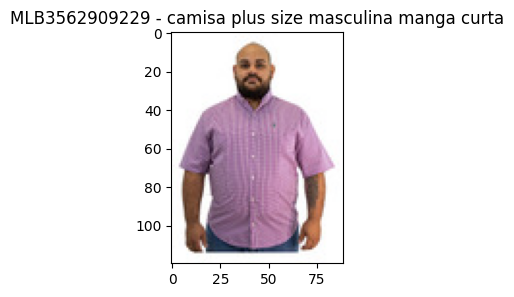

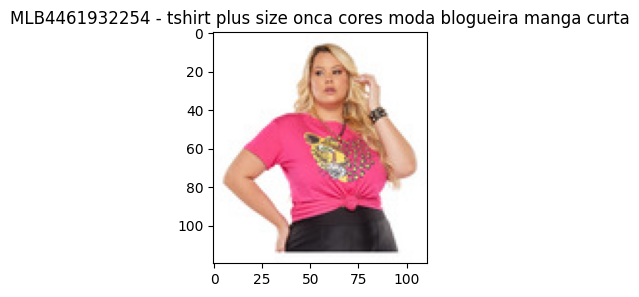

In [48]:
# Get top N similar itens
TOP_N = 3
ind_top = np.argpartition(np.squeeze(sim_scores), -TOP_N)[-TOP_N:].tolist()
ind_top.reverse()
for i, img_path in zip(ind_top, train.loc[ind_top, "thumbnail_path"]):
    img = Image.open(img_path)
    fig, ax = plt.subplots(figsize=(3,3))
    plt.imshow(img)
    _=ax.set_title(f"{train.loc[i, 'item_id']} - {train.loc[i, 'clean_title']}")

In [49]:
# TODO: garantir itens iguais (mesmo Item ID) no mesmo split
# TODO: transformar numa funcao ou classe
# TODO: avaliar melhor método de agragacao entre scores

##### Domains Similarity

In [63]:
# === Recomendação usando SVD nas categorias compradas por cada usuário ===
# Cria uma matriz de compra de usuário por categoria
df_usuario_categoria = sample_items_meli_mod.pivot_table(
    index='buyer_ID',
    columns='ITE_ITEM_DOM_DOMAIN_ID',
    aggfunc='size',
    fill_value=0
)

In [64]:
df_usuario_categoria.shape

(6172, 54)

In [65]:
df_usuario_categoria.head()

ITE_ITEM_DOM_DOMAIN_ID,MLB-BACKPACKS,MLB-BICYCLES,MLB-BLOOD_GLUCOSE_METERS,MLB-BLOUSES,MLB-BODY_SHAPERS,MLB-BODY_SKIN_CARE_PRODUCTS,MLB-BOOTS_AND_BOOTIES,MLB-BRAS,MLB-CHARMS,MLB-DISHWASHING_DETERGENTS,...,MLB-SUPPLEMENTS,MLB-SWEATSHIRTS_AND_HOODIES,MLB-SWIMWEAR,MLB-THERMOSES,MLB-T_SHIRTS,MLB-UNDERPANTS,MLB-VINYL_ROLLS_AND_SHEETS,MLB-WALL_AND_CEILING_LIGHTS,MLB-WATER_HOSES,MLB-WRISTWATCHES
buyer_ID,,,,,,,,,,,,,,,,,,,,,
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2408,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
matriz_usuario_categoria = df_usuario_categoria.values
user_ratings_mean = np.mean(matriz_usuario_categoria, axis = 1)
matriz_usuario_categoria_demeaned = matriz_usuario_categoria - user_ratings_mean.reshape(-1, 1)

In [105]:
# get SVD decompostion using only the top k singular values
U, sigma, Vt = svds(matriz_usuario_categoria_demeaned, k = 20)
# Regenerate ratings martix using multiplication to get predictions
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = df_usuario_categoria.columns)

In [162]:
# Testing domain predictions for user
idx = 201
user_id = df_usuario_categoria.index.values[idx]
user_id

np.int64(61156)

In [163]:
# Get User shop historic
sorted_user_predictions = preds_df.iloc[idx].sort_values(ascending=False)
user_data = sample_items_meli_mod[sample_items_meli_mod.buyer_ID == (user_id)]
user_data

,item_id,ITE_ITEM_TITLE,ITE_ITEM_DOM_DOMAIN_ID,buyer_ID,thumbnail_path,clean_title
96,MLB4457945096,Chinelo Slide Nuvem Infantil Confort Anatômico,MLB-SANDALS_AND_CLOGS,61156,item_thumbs/812730-MLB74635774555_022024.jpeg,chinelo slide nuvem infantil confort anatomico
1020,MLB3455708265,Vestido Fenda Tomara Que Caia Com Bojo,MLB-DRESSES,61156,item_thumbs/734668-MLB74346905442_022024.jpeg,vestido fenda tomara que caia com bojo


In [164]:
# Get predictions
recommendations = sorted_user_predictions.reset_index()["ITE_ITEM_DOM_DOMAIN_ID"].values
recommendations_list = [rec for rec in recommendations if rec not in user_data.ITE_ITEM_DOM_DOMAIN_ID.values][:3]

N_ITEMS_REC = 3
for domain in recommendations_list:
    print("="*100)
    print(f"Items reccomended for domain: {domain}")
    sample_domain = sample_items_meli_mod[sample_items_meli_mod.ITE_ITEM_DOM_DOMAIN_ID==domain].sample(N_ITEMS_REC, random_state=42).reset_index(drop=True)
    for i in range(N_ITEMS_REC):
        print(f"Item ID: {sample_domain.loc[i, "item_id"]} - Title: {sample_domain.loc[i, "ITE_ITEM_TITLE"]}")

Items reccomended for domain: MLB-SKIRTS
Item ID: MLB4641538494 - Title: Conjunto Cropped Manga Única Com Franjas E Saia  Pedrarias
Item ID: MLB3345208657 - Title: Saia Indiana Branca Modelo Simples Com Renda
Item ID: MLB3677354349 - Title: Saia Lápis Midi Sarja Jeans Com Fenda Moda Evangélica
Items reccomended for domain: MLB-HANDBAGS
Item ID: MLB2747688204 - Title: Bolsa Média Barata Gabi Show Lançamento Com Brinde Promoção
Item ID: MLB4923700674 - Title: Mochila Mala Bolsa 3em1 Academia Viagem Impermeável Espaçosa
Item ID: MLB1943329731 - Title: Bolsa Feminina Pequena Transversal Alça Corrente Lançamento
Items reccomended for domain: MLB-BRAS
Item ID: MLB884900997 - Title: Sutiã  De Alta Sustentação Plié 50142 Pós Cirúrgico Estético
Item ID: MLB3578910423 - Title: Sutiâ Sustenção Gallard Control Demillus 78908, Taça B
Item ID: MLB2106839338 - Title: Kit 3 Sutiã Alça Reforçada Sutian Básico Soutien Microfibra 


In [165]:
#TODO: testar valores de k para determinar um valor otimo
#TODO: implementar codigo como funcao